In [1]:
import pandas as pd
import numpy as np
# Load the dataset
file_path = './close.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand its structure
data.head()

,close
0,4261.48
1,4261.45
2,4310.07
3,4308.83
4,4304.31


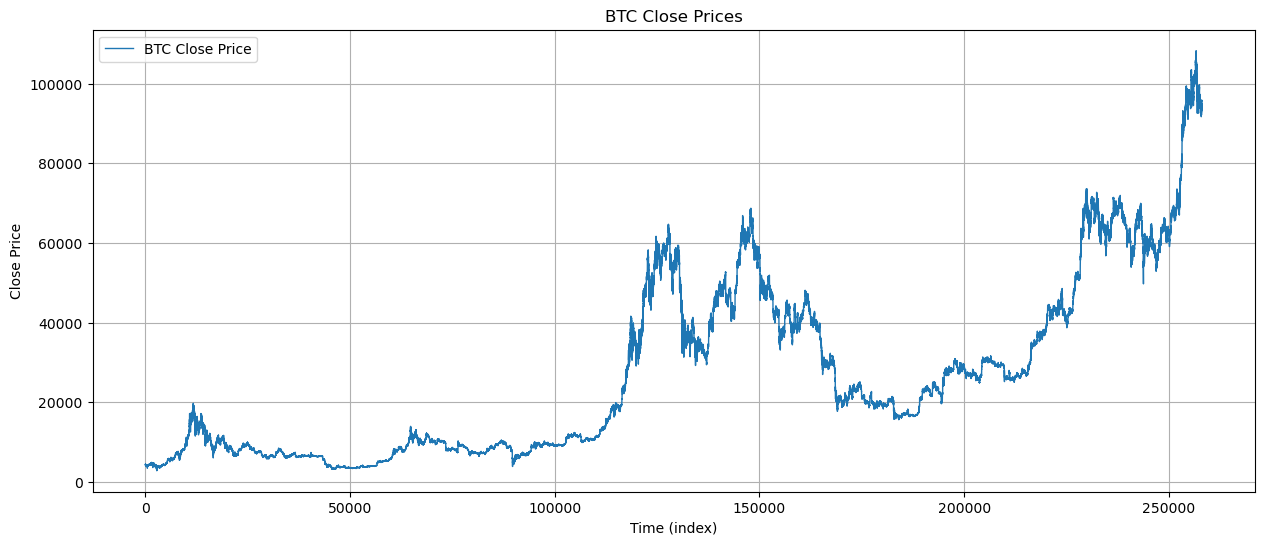

In [2]:
import matplotlib.pyplot as plt

# Plot the closing prices to visualize the data
plt.figure(figsize=(15, 6))
plt.plot(data['close'], label='BTC Close Price', linewidth=1)
plt.title('BTC Close Prices')
plt.xlabel('Time (index)')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()


In [3]:
from PyEMD import EMD


# Extract the smoothed data for EMD (or raw data if preferred)
signal = data['close'].values

# Perform EMD
emd = EMD()
imfs = emd(signal)

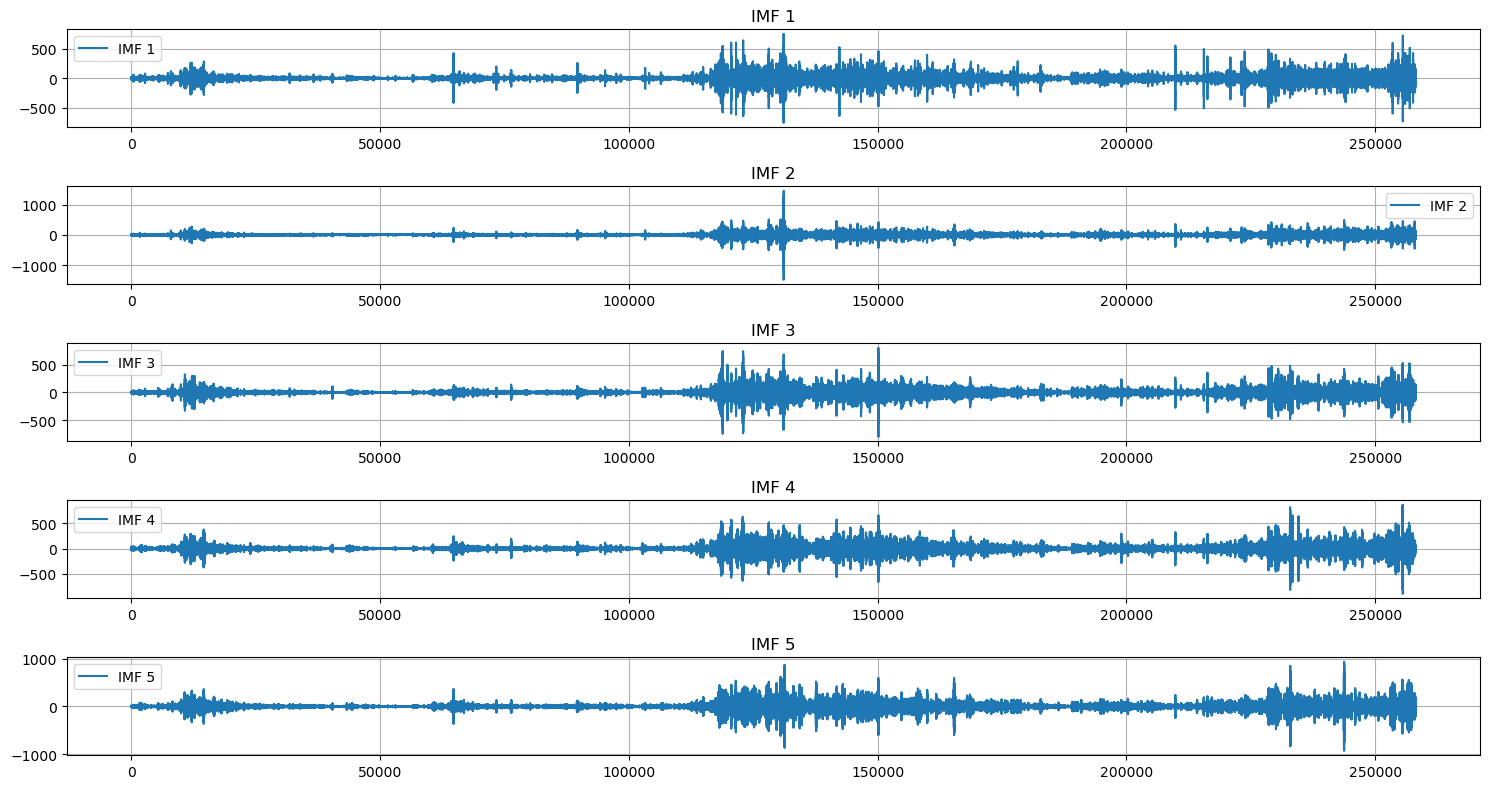

In [4]:
# Plot the first few IMFs
plt.figure(figsize=(15, 8))
for i, imf in enumerate(imfs[:5]):  # Plot the first 5 IMFs
    plt.subplot(5, 1, i + 1)
    plt.plot(imf, label=f'IMF {i + 1}')
    plt.title(f'IMF {i + 1}')
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()

In [39]:
# Add the first few IMFs (e.g., IMF 1 and IMF 2) to the dataset
selected_imfs = [imfs[2], imfs[3], imfs[4], imfs[5], imfs[6]]  # Adjust based on your analysis
for i, imf in enumerate(selected_imfs):
    data[f'IMF_{i+1}'] = imf

print("File saved as 'augmented_with_imfs.csv'")

File saved as 'augmented_with_imfs.csv'


In [40]:
reconstructed_signal = np.sum(selected_imfs, axis=0)

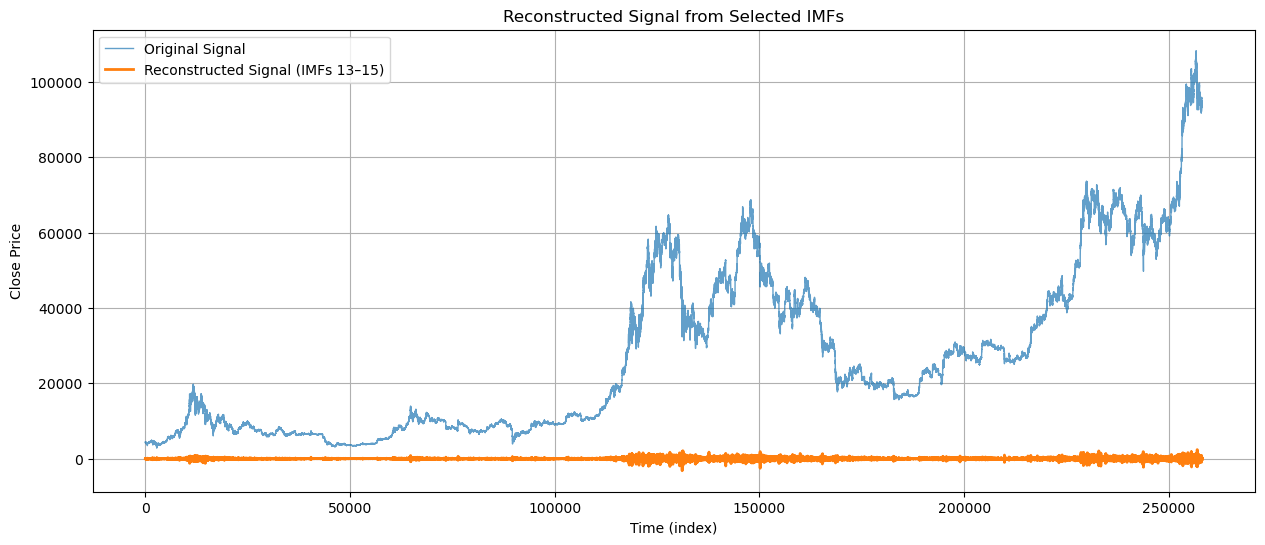

In [41]:
# Step 3: Visualize the reconstructed signal
plt.figure(figsize=(15, 6))
plt.plot(data['close'], label='Original Signal', linewidth=1, alpha=0.7)
plt.plot(reconstructed_signal, label='Reconstructed Signal (IMFs 13–15)', linewidth=2)
plt.title('Reconstructed Signal from Selected IMFs')
plt.xlabel('Time (index)')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

In [42]:
from scipy.signal import argrelextrema
order = 7
local_maxima = argrelextrema(reconstructed_signal, comparator=np.greater, order=order)[0]
local_minima = argrelextrema(reconstructed_signal, comparator=np.less, order=order)[0]


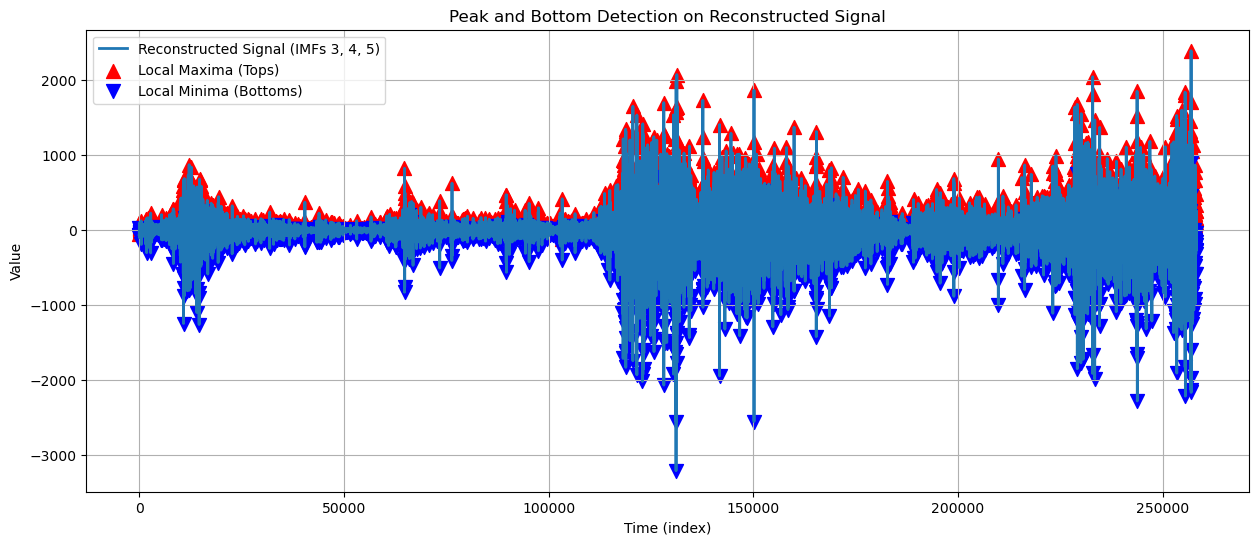

Detection completed. Results saved to 'output_with_peaks_and_bottoms.csv'.


In [43]:
# Step 5: Plot the reconstructed signal with detected extrema
plt.figure(figsize=(15, 6))
plt.plot(reconstructed_signal, label='Reconstructed Signal (IMFs 3, 4, 5)', linewidth=2)
plt.scatter(local_maxima, reconstructed_signal[local_maxima], color='red', label='Local Maxima (Tops)', marker='^', s=100)
plt.scatter(local_minima, reconstructed_signal[local_minima], color='blue', label='Local Minima (Bottoms)', marker='v', s=100)
plt.title('Peak and Bottom Detection on Reconstructed Signal')
plt.xlabel('Time (index)')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

# Step 6: Save the results
data['reconstructed_signal'] = reconstructed_signal
data['is_peak'] = False
data['is_bottom'] = False
data.loc[local_maxima, 'is_peak'] = True
data.loc[local_minima, 'is_bottom'] = True
data.to_csv("output_with_peaks_and_bottoms.csv", index=False)

print("Detection completed. Results saved to 'output_with_peaks_and_bottoms.csv'.")

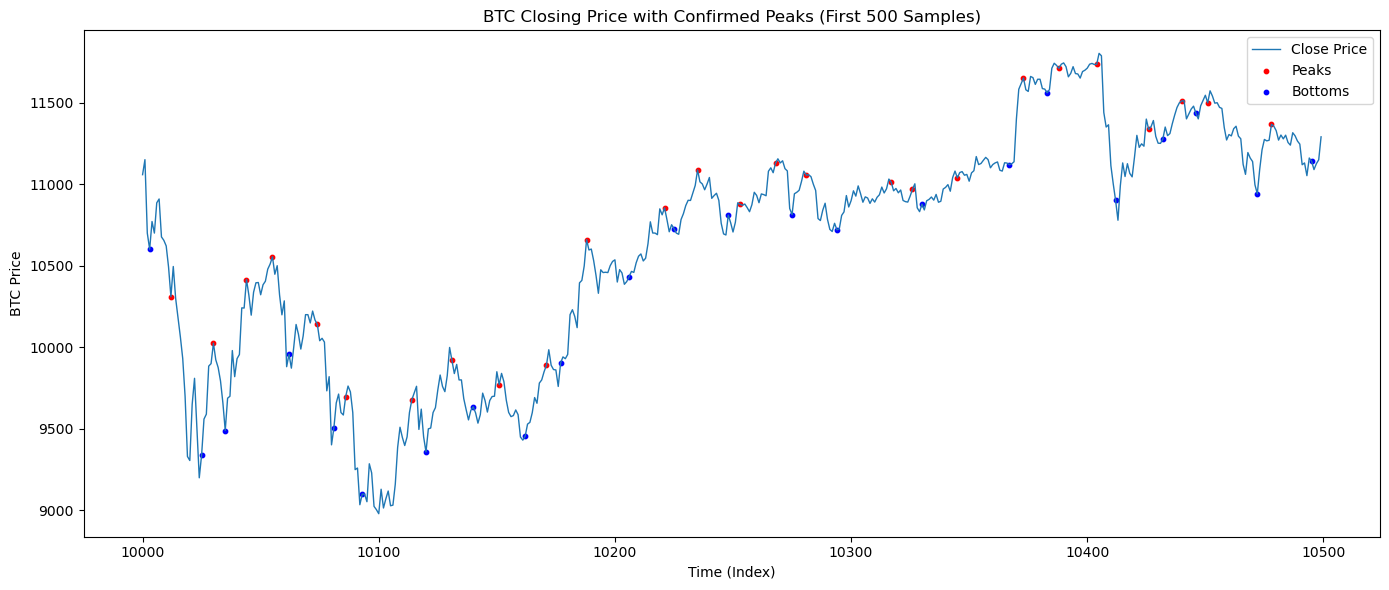

In [44]:
def visualize_peaks_limited_raw(data,offset=10000, sample_size=500):
    """
    Visualize the closing price and detected peaks on a line chart with limited data.
    """
    # Limit the data to the first sample_size entries
    limited_data = data.iloc[offset:offset+sample_size]

    plt.figure(figsize=(14, 6))
    plt.plot(limited_data['close'], label='Close Price', linewidth=1)

    # Plot confirmed peaks
    peak_indices = limited_data[limited_data['is_peak']].index
    bottom_indices = limited_data[limited_data['is_bottom']].index
    plt.scatter(peak_indices, limited_data.loc[peak_indices, 'close'], color='red', label='Peaks', s=10)
    plt.scatter(bottom_indices, limited_data.loc[bottom_indices, 'close'], color='blue', label='Bottoms', s=10)

    plt.title(f"BTC Closing Price with Confirmed Peaks (First {sample_size} Samples)")
    plt.xlabel("Time (Index)")
    plt.ylabel("BTC Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

visualize_peaks_limited_raw(data, offset=10000, sample_size=500)

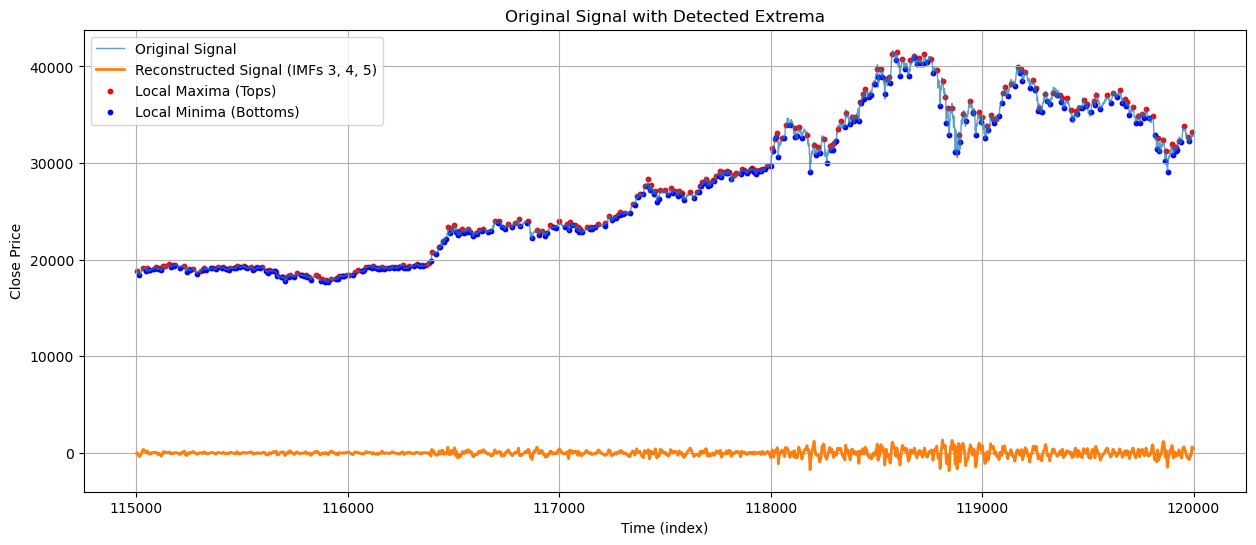

In [45]:
# Step 5: Label the original dataset
data['reconstructed_signal'] = reconstructed_signal
data['is_peak'] = False
data['is_bottom'] = False
data.loc[local_maxima, 'is_peak'] = True
data.loc[local_minima, 'is_bottom'] = True

# Focus on a subset of the data for better visualization
shorted_data = data.iloc[115000:120000]

# Step 6: Plot the original signal, reconstructed signal, and labeled extrema
plt.figure(figsize=(15, 6))
plt.plot(shorted_data['close'], label='Original Signal', linewidth=1, alpha=0.7)
plt.plot(shorted_data['reconstructed_signal'], label='Reconstructed Signal (IMFs 3, 4, 5)', linewidth=2)

# Plot is_peak and is_bottom points from the dataset
plt.scatter(
    shorted_data.index[shorted_data['is_peak']],
    shorted_data['close'][shorted_data['is_peak']],
    color='red',
    label='Local Maxima (Tops)',
    marker='o',
    s=10
)
plt.scatter(
    shorted_data.index[shorted_data['is_bottom']],
    shorted_data['close'][shorted_data['is_bottom']],
    color='blue',
    label='Local Minima (Bottoms)',
    marker='o',
    s=10
)

plt.title('Original Signal with Detected Extrema')
plt.xlabel('Time (index)')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

In [46]:
# Scale reconstructed signal to match the range of the original signal
scaled_reconstructed_signal = (
    (reconstructed_signal - reconstructed_signal.min())
    / (reconstructed_signal.max() - reconstructed_signal.min())
    * (data['close'].max() - data['close'].min())
    + data['close'].min()
)

data['scaled_reconstructed_signal'] = scaled_reconstructed_signal

In [47]:
def visualize_peaks_limited(data, offsize=20000, sample_size=500, window_size=5, threshold=0.01, show_removed=False):
    """
    Visualize the closing price and detected peaks on a line chart with limited data.
    """
    # Limit the data to the first sample_size entries
    limited_data = data.iloc[offsize:offsize+sample_size]

    plt.figure(figsize=(14, 6))
    plt.plot(limited_data['close'], label='Close Price', linewidth=1)

    # Plot confirmed peaks
    peak_indices = limited_data[limited_data['confirmed_peak']].index
    bottom_indicies = limited_data[limited_data['confirmed_bottom']].index
    removoved_peaks = limited_data[limited_data['is_removed']].index
    total_peaks = len(peak_indices) + len(bottom_indicies)
    print(f"Total Peaks: {total_peaks} out of {sample_size} samples")

    plt.scatter(peak_indices, limited_data.loc[peak_indices, 'close'], color='red', label='Confirmed Peaks', s=10)
    plt.scatter(bottom_indicies, limited_data.loc[bottom_indicies, 'close'], color='blue', label='Confirmed Peaks', s=10)
    if show_removed:
        plt.scatter(removoved_peaks, limited_data.loc[removoved_peaks, 'close'], color='green', label='Removed Peaks', s=10)
    
    plt.title(f"BTC Closing Price with Confirmed Peaks (First {sample_size} Samples)")
    plt.xlabel("Time (Index)")
    plt.ylabel("BTC Price")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"off_{offsize}_windows_{window_size}_threshold{threshold}.png")

In [48]:
def detect_peaks_stack(data, window_size=50, threshold=0.01, big_threshold=0.05, temperature=0.5, max_iterations=100000, log_file="removed_peaks_log.txt"):
    closes = data['close'].values
    is_peak = data['is_peak'].values.copy()
    confirmed_peaks = []
    removed_peaks = []

    # Use a stack for peak refinement
    peak_stack = list(np.where(is_peak)[0])

    with open(log_file, "w") as log:
        while peak_stack:
            idx = peak_stack.pop()
            iteration = 0
            visited_indices = set()

            while iteration < max_iterations:
                iteration += 1

                # Define the window and avoid errors
                window_start = max(0, idx - window_size // 2)
                window_end = min(len(closes), idx + window_size // 2 + 1)
                window = closes[window_start:window_end]

                if temperature <= 0:
                    temperature = 0.01

                # Compute softmax probabilities for exploration
                shifted_window = window - np.max(window)
                scores = np.exp(np.clip(shifted_window / temperature, -700, 700))
                probabilities = scores / np.sum(scores)

                # Exploration vs Exploitation Decision with Reverse Chance
                if np.random.rand() < temperature:
                    # Explore: Random move based on probabilities
                    chosen_idx_offset = np.random.choice(len(window), p=probabilities)
                    candidate_idx = window_start + chosen_idx_offset
                else:
                    # Exploit: Move to the highest point deterministically
                    candidate_idx = np.argmax(window) + window_start

                # Prevent revisiting the same point
                if idx in visited_indices:
                    break
                visited_indices.add(idx)

                # Confirm the peak if conditions are met
                max_value_in_window = np.max(window)
                min_value_in_window = np.min(window)
                left_side_min = np.min(closes[window_start:idx])
                if max_value_in_window > closes[idx]:
                    if closes[idx] > left_side_min * (1 + big_threshold):
                        confirmed_peaks.append(idx)
                        break
                    else:
                        peak_stack.append(candidate_idx)
                        break


                if closes[idx] > min_value_in_window * (1 + threshold):
                    confirmed_peaks.append(idx)
                    break
                else:
                    log.write(f"{idx} - Top,Failed to meet the first threshold with value {closes[idx]} < {min_value_in_window * (1 + threshold)}\n")
                    removed_peaks.append(idx)
                    break

    # Update the DataFrame with the refined peaks
    data['confirmed_peak'] = False
    data['is_removed'] = False
    data.loc[confirmed_peaks, 'confirmed_peak'] = True
    data.loc[removed_peaks, 'is_removed'] = True

    return data



In [49]:
def detect_bottoms_stack(data, window_size=50, threshold=0.01, big_threshold=0.07, temperature=0.5, max_iterations=100000, log_file="removed_peaks_log.txt"):
    closes = data['close'].values
    is_bottom = data['is_bottom'].values.copy()
    confirmed_bottoms = []
    removed_bottoms = []

    bottom_stack = list(np.where(is_bottom)[0])

    with open(log_file, "w") as log:
        log.write("Index,Reason\n")
        while bottom_stack:
            idx = bottom_stack.pop()
            iteration = 0
            visited_indices = set()

            while iteration < max_iterations:
                iteration += 1

                window_start = max(0, idx - window_size // 2)
                window_end = min(len(closes), idx + window_size // 2 + 1)
                window = closes[window_start:window_end]

                if temperature <= 0:
                    temperature = 0.01

                shifted_window = window - np.min(window)
                scores = np.exp(np.clip(-shifted_window / temperature, -700, 700))
                probabilities = scores / np.sum(scores)

                if np.random.rand() < temperature:
                    chosen_idx_offset = np.random.choice(len(window), p=probabilities)
                    candidate_idx = window_start + chosen_idx_offset
                else:
                    candidate_idx = np.argmin(window) + window_start

                if idx in visited_indices:
                    break
                visited_indices.add(idx)

                min_value_in_window = np.min(window)
                max_value_in_window = np.max(window)
                if window_start == idx or len(closes[window_start:idx]) == 0:
                    left_side_max = closes[idx]  # Set to current value or a default
                else:
                    left_side_max = np.max(closes[window_start:idx])
                if min_value_in_window < closes[idx]:
                    if closes[idx] < left_side_max * (1 - big_threshold):
                        confirmed_bottoms.append(idx)
                        break
                    else:
                        bottom_stack.append(candidate_idx)
                        break
                 
                if closes[idx] < max_value_in_window * (1 - threshold):
                    confirmed_bottoms.append(idx)
                    break
                else:
                    log.write(f"{idx} - Bottom,Failed to meet the first threshold with value {closes[idx]} > {max_value_in_window * (1 - threshold)}\n")
                    removed_bottoms.append(idx)
                    break

        data['confirmed_bottom'] = False
        data['is_removed'] = False
        data.loc[confirmed_bottoms, 'confirmed_bottom'] = True
        data.loc[removed_bottoms, 'is_removed'] = True

        return data

In [58]:
window_size = 7
threshold = 0.005
big_threshold = 0.01
temperature = 0.5
stack_data = detect_peaks_stack(data=data, window_size=window_size, threshold=threshold, big_threshold=big_threshold, temperature=temperature)
stack_data = detect_bottoms_stack(data=data, window_size=window_size, threshold=threshold, big_threshold=big_threshold, temperature=temperature)

Total Peaks: 88 out of 1000 samples


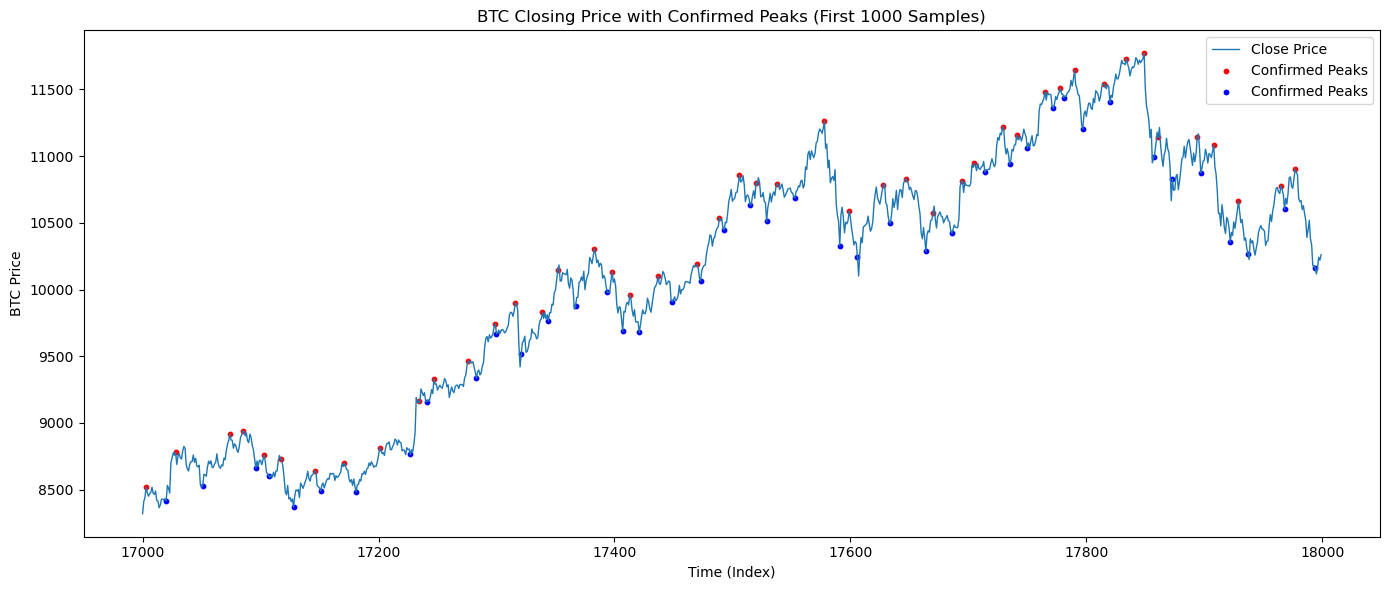

In [59]:
visualize_peaks_limited(stack_data, 17000, 1000, window_size, threshold)

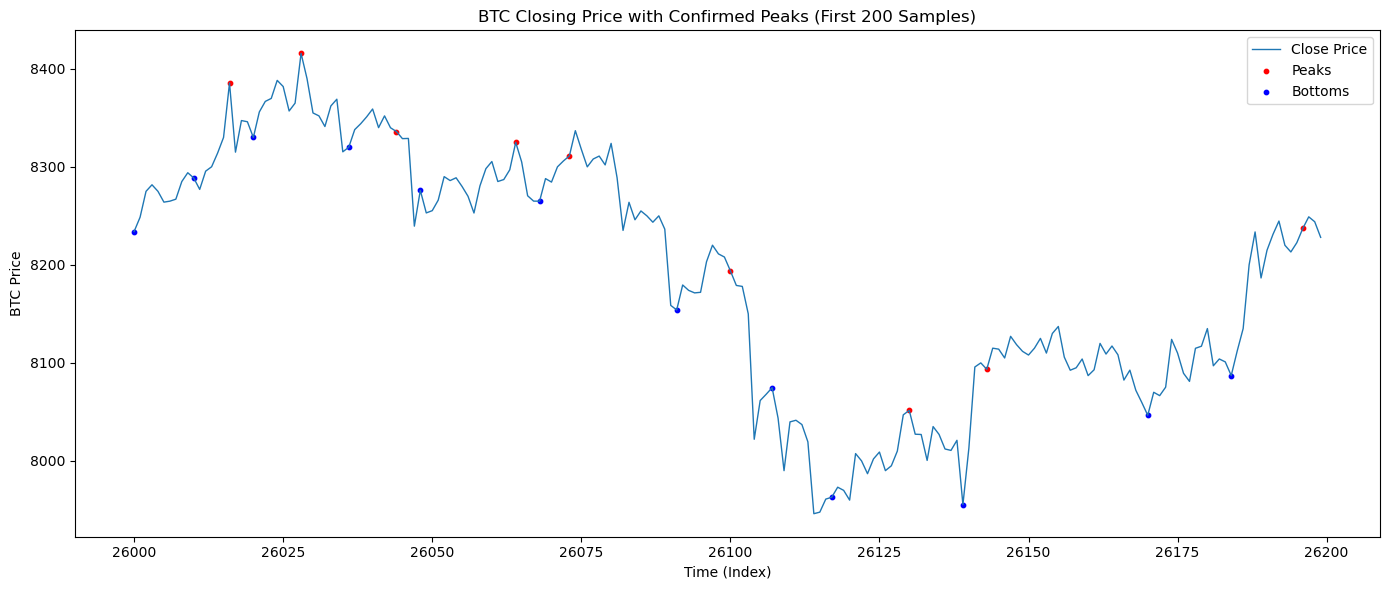

In [52]:
visualize_peaks_limited_raw(data, 26000, 200)

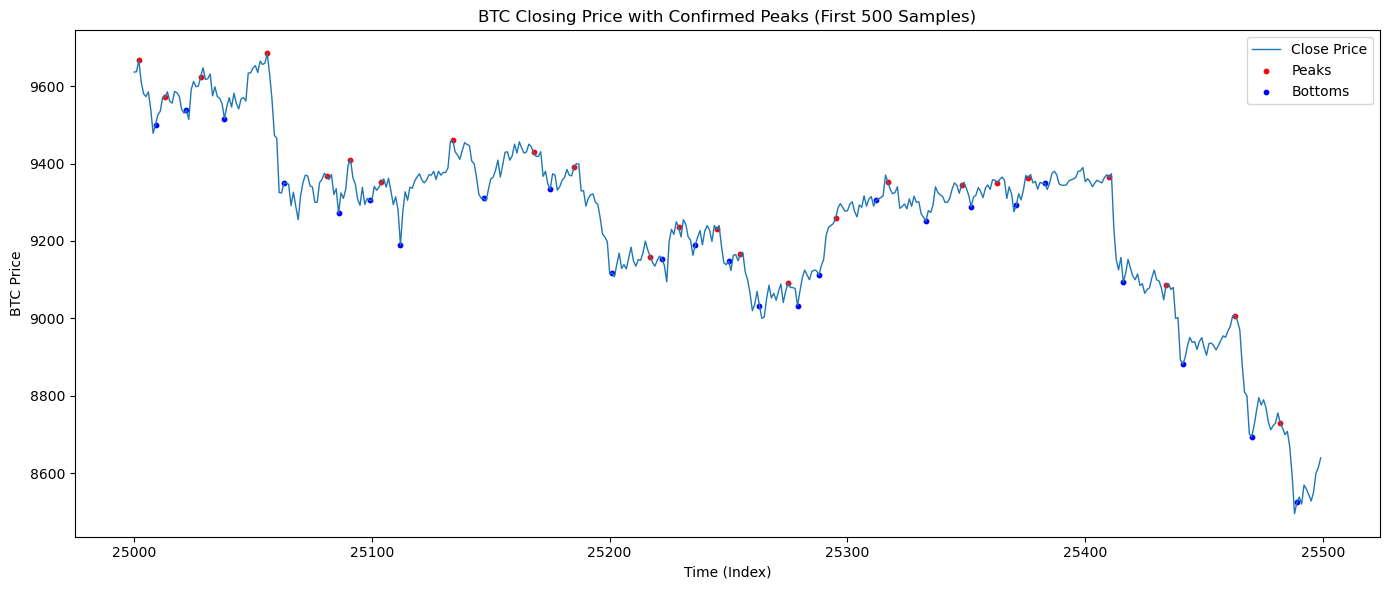

In [53]:
visualize_peaks_limited_raw(data, 25000, 500)

In [54]:
stack_data.head()

,close,IMF_1,IMF_2,IMF_3,IMF_4,IMF_5,reconstructed_signal,is_peak,is_bottom,scaled_reconstructed_signal,confirmed_peak,is_removed,confirmed_bottom
0,4261.48,3.517869,-4.191781,-14.165796,-40.121848,-18.348525,-73.310082,False,False,61826.674724,False,False,False
1,4261.45,4.442845,3.092537,-15.000871,-43.394235,-22.405426,-73.265150,False,False,61827.520483,False,False,True
2,4310.07,0.000071,13.515114,-15.683220,-45.802267,-25.923049,-73.893351,False,True,61815.695611,False,False,False
3,4308.83,-4.439049,24.649632,-16.129746,-47.271544,-28.867146,-72.057854,False,False,61850.245895,False,False,False
4,4304.31,-3.780973,33.805968,-16.257353,-47.727668,-31.203470,-65.163496,False,False,61980.021133,False,False,False


In [55]:
output_data = stack_data[['close', 'confirmed_bottom', 'confirmed_peak']] 
output_data.to_csv("output.csv", index=False)